# Model 2
## Use the cluster as a feature. Then run Random Forest on the entire dataset.

In [123]:
import pandas as pd 
import numpy as np
import sklearn as sk
import random
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold


## Merge the train and test datsets

In [124]:
pd.set_option('display.max_columns', None)

# Load the dfs
train_df = pd.read_csv('train_processed.csv')
test_df = pd.read_csv('test_processed.csv')

# Find the lengths of the train and test dataframes
train_size = len(train_df)
test_size = len(test_df)

# combine them for unsupervised learning
combined_df = pd.concat([train_df, test_df], axis=0)

# save the price and id columns for later
price_column = combined_df['price']
id_column = combined_df['id']

combined_df = combined_df.drop(columns=['price','id'])

combined_df = combined_df.reset_index(drop=True)
price_column = price_column.reset_index(drop=True)
id_column = id_column.reset_index(drop=True)

combined_df


,latitude,longitude,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,calculated_host_listings_count,accommodates,bathrooms,bedrooms,beds,has_availability,availability_30,availability_60,availability_90,availability_365,instant_bookable,minimum_nights,maximum_nights,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,room_Entire home/apt,room_Hotel room,room_Private room,room_Shared room,Air conditioning,Kitchen,Dedicated workspace,Heating,Hot water,Refrigerator,Free street parking,Self check-in,Shampoo,Washer
0,40.684560,-73.939870,16578,2.0,100.0,100.0,1,2.0,2.0,1,1,1,4,2.0,2.0,2.0,1,12,42,70,70,False,30,1125,34,5,1,18014,19945,5.000000,5.000000,4.970000,5.000000,5.000000,4.710000,4.940000,0.520000,1,0,0,0,0,1,0,1,1,1,1,1,1,0
1,40.638991,-73.965739,19614,1.0,100.0,98.0,1,1.0,1.0,1,1,1,2,1.0,1.0,2.0,1,10,20,49,324,False,1,29,30,30,6,19735,19968,4.830000,4.870000,4.930000,4.800000,4.900000,4.900000,4.630000,3.810000,0,0,1,0,1,1,0,0,1,0,1,1,1,0
2,40.618810,-74.032380,19204,1.0,100.0,100.0,0,52.0,55.0,1,1,52,2,1.0,0.0,1.0,1,17,44,70,146,True,1,29,5,5,2,19901,19952,4.600000,4.800000,4.200000,4.800000,4.800000,4.800000,4.200000,2.140000,1,0,0,0,1,0,1,1,1,0,0,1,1,0
3,40.673970,-73.953990,15563,1.0,99.0,23.0,0,727.0,1336.0,1,1,719,1,1.5,4.0,1.0,1,0,0,0,111,False,30,365,0,0,0,20049,20049,4.719393,4.742812,4.679642,4.826310,4.808233,4.721844,4.609505,1.245801,0,0,1,0,0,1,1,1,1,1,0,0,0,1
4,40.747180,-73.985390,16427,1.0,93.0,95.0,0,707.0,2453.0,1,1,73,2,1.0,1.0,1.0,1,4,13,22,241,True,1,1125,0,0,0,20049,20049,4.719393,4.742812,4.679642,4.826310,4.808233,4.721844,4.609505,1.245801,0,1,0,0,1,0,1,1,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22418,40.637960,-73.951360,16690,1.0,100.0,100.0,0,2.0,2.0,1,1,2,2,1.0,2.0,6.0,1,30,60,90,365,False,30,1125,325,9,0,16729,19679,4.710000,4.750000,4.640000,4.880000,4.900000,4.650000,4.710000,3.010000,0,0,1,0,0,1,1,1,1,1,1,1,1,0
22419,40.823720,-73.945460,16877,4.0,0.0,33.0,0,7.0,8.0,1,0,7,1,1.0,1.0,1.0,1,0,1,1,97,False,30,365,11,2,0,17774,19875,4.360000,4.550000,4.550000,4.910000,4.550000,4.910000,4.450000,0.150000,0,0,1,0,1,0,1,1,0,0,0,1,0,0
22420,40.755094,-73.937260,15563,1.0,99.0,23.0,0,727.0,1336.0,1,1,719,1,3.0,5.0,1.0,1,3,33,63,159,False,30,365,0,0,0,20049,20049,4.711449,4.748402,4.673496,4.813213,4.800491,4.710323,4.604796,1.234094,0,0,1,0,1,1,1,1,1,1,0,0,0,0
22421,40.781580,-73.984780,15351,1.0,100.0,100.0,1,1.0,3.0,1,1,1,2,1.0,1.0,1.0,1,18,35,35,35,False,30,30,33,6,0,18962,19906,4.880000,4.940000,4.730000,4.940000,5.000000,4.850000,4.760000,0.980000,1,0,0,0,1,1,1,0,1,1,0,0,1,0


## Normalize the dataset

In [125]:
# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Normalize all columns
combined_df[:] = scaler.fit_transform(combined_df)

combined_df

/var/folders/2f/7sxq51rj0xd8mgyvzzj2tgy80000gn/T/ipykernel_82843/2371048953.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.42223738 0.93997271 0.87005457 ... 0.24914734 0.21299454 0.54297408]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  combined_df[:] = scaler.fit_transform(combined_df)
/var/folders/2f/7sxq51rj0xd8mgyvzzj2tgy80000gn/T/ipykernel_82843/2371048953.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.         0.         0.05828571 ... 0.82057143 0.         0.00228571]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  combined_df[:] = scaler.fit_transform(combined_df)
/var/folders/2f/7sxq51rj0xd8mgyvzzj2tgy80000gn/T/ipykernel_82843/2371048953.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a futur

,latitude,longitude,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,calculated_host_listings_count,accommodates,bathrooms,bedrooms,beds,has_availability,availability_30,availability_60,availability_90,availability_365,instant_bookable,minimum_nights,maximum_nights,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,room_Entire home/apt,room_Hotel room,room_Private room,room_Shared room,Air conditioning,Kitchen,Dedicated workspace,Heating,Hot water,Refrigerator,Free street parking,Self check-in,Shampoo,Washer
0,0.448134,0.579717,0.422237,0.333333,1.00,1.00,1,0.000223,0.000111,1,1,0.000000,0.200000,0.173913,0.222222,0.1250,1,0.400000,0.700000,0.777778,0.191781,0.0,0.058116,0.112411,0.017517,0.002822,0.006803,0.640459,0.978017,1.000000,1.000000,0.992500,1.000000,1.000000,0.927500,0.985000,0.004633,1,0,0,0,0,1,0,1,1,1,1,1,1,0
1,0.337268,0.531656,0.939973,0.000000,1.00,0.98,1,0.000000,0.000000,1,1,0.000000,0.066667,0.086957,0.111111,0.1250,1,0.333333,0.333333,0.544444,0.887671,0.0,0.000000,0.002800,0.015456,0.016930,0.040816,0.944523,0.982879,0.957500,0.967500,0.982500,0.950000,0.975000,0.975000,0.907500,0.034517,0,0,1,0,1,1,0,0,1,0,1,1,1,0
2,0.288168,0.407848,0.870055,0.000000,1.00,1.00,0,0.011351,0.005988,1,1,0.058286,0.066667,0.086957,0.000000,0.0625,1,0.566667,0.733333,0.777778,0.400000,1.0,0.000000,0.002800,0.002576,0.002822,0.013605,0.973852,0.979497,0.900000,0.950000,0.800000,0.950000,0.950000,0.950000,0.800000,0.019348,1,0,0,0,1,0,1,1,1,0,0,1,1,0
3,0.422369,0.553485,0.249147,0.000000,0.99,0.23,0,0.161585,0.148037,1,1,0.820571,0.000000,0.130435,0.444444,0.0625,1,0.000000,0.000000,0.000000,0.304110,0.0,0.058116,0.036404,0.000000,0.000000,0.000000,1.000000,1.000000,0.929848,0.935703,0.919910,0.956577,0.952058,0.930461,0.902376,0.011225,0,0,1,0,0,1,1,1,1,1,0,0,0,1
4,0.600485,0.495148,0.396487,0.000000,0.93,0.95,0,0.157133,0.271901,1,1,0.082286,0.066667,0.086957,0.111111,0.0625,1,0.133333,0.216667,0.244444,0.660274,1.0,0.000000,0.112411,0.000000,0.000000,0.000000,1.000000,1.000000,0.929848,0.935703,0.919910,0.956577,0.952058,0.930461,0.902376,0.011225,0,1,0,0,1,0,1,1,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22418,0.334759,0.558371,0.441337,0.000000,1.00,1.00,0,0.000223,0.000111,1,1,0.001143,0.066667,0.086957,0.222222,0.3750,1,1.000000,1.000000,1.000000,1.000000,0.0,0.058116,0.112411,0.167439,0.005079,0.000000,0.413428,0.921792,0.927500,0.937500,0.910000,0.970000,0.975000,0.912500,0.927500,0.027250,0,0,1,0,0,1,1,1,1,1,1,1,1,0
22419,0.786703,0.569332,0.473226,1.000000,0.00,0.33,0,0.001335,0.000776,1,0,0.006857,0.000000,0.086957,0.111111,0.0625,1,0.000000,0.016667,0.011111,0.265753,0.0,0.058116,0.036404,0.005667,0.001129,0.000000,0.598057,0.963221,0.840000,0.887500,0.887500,0.977500,0.887500,0.977500,0.862500,0.001272,0,0,1,0,1,0,1,1,0,0,0,1,0,0
22420,0.619740,0.584566,0.249147,0.000000,0.99,0.23,0,0.161585,0.148037,1,1,0.820571,0.000000,0.260870,0.555556,0.0625,1,0.100000,0.550000,0.700000,0.435616,0.0,0.058116,0.036404,0.000000,0.000000,0.000000,1.000000,1.000000,0.927862,0.937101,0.918374,0.953303,0.950123,0.927581,0.901199,0.011119,0,0,1,0,1,1,1,1,1,1,0,0,0,0
22421,0.684179,0.496282,0.212995,0.000000,1.00,1.00,1,0.000000,0.000222,1,1,0.000000,0.066667,0.086957,0.111111,0.0625,1,0.600000,0.583333,0.388889,0.095890,0.0,0.058116,0.002900,0.017002,0.003386,0.000000,0.807951,0.969774,0.970000,0.985000,0.932500,0.985000,1.000000,0.962500,0.940000,0.008811,1,0,0,0,1,1,1,0,1,1,0,0,1,0


# Unsupervised Learning: Neighborhood Analysis
## Use KNN to find averaged neighborhood representations

In [126]:
# Find k1 nearest neighbors
# Compute average representations of each property according to its k1 nearest neighbors
def knn(combined_df, k1):
    # Extract longitude and latitude for KNN (ignore them when averaging features)
    coordinates = combined_df[['longitude', 'latitude']].values

    # Initialize the KNN model (for 500 neighbors)
    knn = NearestNeighbors(n_neighbors=k1)

    # Fit the KNN model
    knn.fit(coordinates)

    # Step 5: Find the 20 nearest neighbors for each property (including itself)
    distances, indices = knn.kneighbors(coordinates)

    # Identify the feature columns
    feature_columns = combined_df.columns[1:]  # All columns starting from index 2 onward

    # Create an empty array to store the averaged features
    averaged_features = np.zeros((combined_df.shape[0], len(feature_columns)))

    # For each property, average its own features and those of the 200 nearest neighbors
    for i in range(combined_df.shape[0]):
        # Get the indices of the neighbors (including the property itself)
        neighbor_indices = indices[i]
        
        # Extract the features for the neighbors
        neighbor_features = combined_df.iloc[neighbor_indices][feature_columns]

        # Ensure the neighbor features are in the same order as feature_columns
        neighbor_features = neighbor_features[feature_columns]

        # Average the features of the property and its neighbors, handling missing values
        averaged_features[i] = neighbor_features.mean(axis=0, skipna=True)
    
    # Create a DataFrame for the averaged features
    averaged_df = pd.DataFrame(averaged_features, columns=feature_columns)

    return averaged_df

# Run an example with k1 = 500
averaged_df = knn(combined_df, 500)

## K-means clustering on averaged neighbor representations

/var/folders/2f/7sxq51rj0xd8mgyvzzj2tgy80000gn/T/ipykernel_82843/2197263031.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', 20)  # Use the 'tab20' colormap with 20 distinct colors
/var/folders/2f/7sxq51rj0xd8mgyvzzj2tgy80000gn/T/ipykernel_82843/2197263031.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


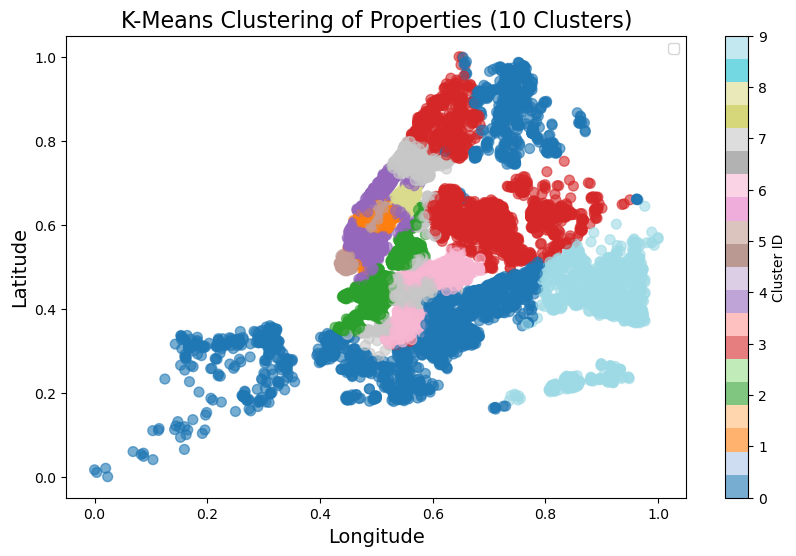

In [127]:
# K-means on averaged neighborhood representations, computes k2 clusters and returns the new combined dataframe with

def k_means(k2, averaged_df):

    # Step 1: Apply KMeans clustering on the averaged features
    kmeans = KMeans(n_clusters=k2, random_state=42)  # 10 clusters
    averaged_df['cluster'] = kmeans.fit_predict(averaged_df)  # Assign clusters to averaged_df

    # Map the clusters back to the original dataframe (df)
    df = combined_df.merge(averaged_df[['cluster']], left_index=True, right_index=True)

    # Step 3: Retrieve cluster centroids
    centroids = kmeans.cluster_centers_

    return df, centroids

def plot_cluster(df,k2):
    # Plot the clusters and their centroids
    plt.figure(figsize=(10, 6))

    # Define a colormap with more distinct colors
    cmap = plt.cm.get_cmap('tab20', 20)  # Use the 'tab20' colormap with 20 distinct colors

    # Plot each property with its assigned cluster (color-coded)
    scatter = plt.scatter(df['longitude'], df['latitude'], c=df['cluster'], cmap=cmap, alpha=0.6, s=50)

    # Add a colorbar for reference
    plt.colorbar(scatter, label='Cluster ID')

    # Add labels and title
    plt.xlabel('Longitude', fontsize=14)
    plt.ylabel('Latitude', fontsize=14)
    plt.title(f'K-Means Clustering of Properties ({k2} Clusters)', fontsize=16)
    plt.legend()

    # Display the plot
    plt.show()

# Run an example with k2 = 10
df, centroids = k_means(10, averaged_df)
plot_cluster(df,10)

## One-hot Encoding of Cluster Columnn and Dataframe Split

In [128]:
def one_hot_cluster(df):
    # One-hot Encode Cluster Column
    df = pd.get_dummies(df, columns=['cluster'], prefix='cluster', dummy_na=False)
    return df

# Example
df = one_hot_cluster(df)
df

,latitude,longitude,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,calculated_host_listings_count,accommodates,bathrooms,bedrooms,beds,has_availability,availability_30,availability_60,availability_90,availability_365,instant_bookable,minimum_nights,maximum_nights,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,room_Entire home/apt,room_Hotel room,room_Private room,room_Shared room,Air conditioning,Kitchen,Dedicated workspace,Heating,Hot water,Refrigerator,Free street parking,Self check-in,Shampoo,Washer,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9
0,0.448134,0.579717,0.422237,0.333333,1.00,1.00,1,0.000223,0.000111,1,1,0.000000,0.200000,0.173913,0.222222,0.1250,1,0.400000,0.700000,0.777778,0.191781,0.0,0.058116,0.112411,0.017517,0.002822,0.006803,0.640459,0.978017,1.000000,1.000000,0.992500,1.000000,1.000000,0.927500,0.985000,0.004633,1,0,0,0,0,1,0,1,1,1,1,1,1,0,False,False,False,False,False,False,False,True,False,False
1,0.337268,0.531656,0.939973,0.000000,1.00,0.98,1,0.000000,0.000000,1,1,0.000000,0.066667,0.086957,0.111111,0.1250,1,0.333333,0.333333,0.544444,0.887671,0.0,0.000000,0.002800,0.015456,0.016930,0.040816,0.944523,0.982879,0.957500,0.967500,0.982500,0.950000,0.975000,0.975000,0.907500,0.034517,0,0,1,0,1,1,0,0,1,0,1,1,1,0,False,False,False,False,False,False,True,False,False,False
2,0.288168,0.407848,0.870055,0.000000,1.00,1.00,0,0.011351,0.005988,1,1,0.058286,0.066667,0.086957,0.000000,0.0625,1,0.566667,0.733333,0.777778,0.400000,1.0,0.000000,0.002800,0.002576,0.002822,0.013605,0.973852,0.979497,0.900000,0.950000,0.800000,0.950000,0.950000,0.950000,0.800000,0.019348,1,0,0,0,1,0,1,1,1,0,0,1,1,0,True,False,False,False,False,False,False,False,False,False
3,0.422369,0.553485,0.249147,0.000000,0.99,0.23,0,0.161585,0.148037,1,1,0.820571,0.000000,0.130435,0.444444,0.0625,1,0.000000,0.000000,0.000000,0.304110,0.0,0.058116,0.036404,0.000000,0.000000,0.000000,1.000000,1.000000,0.929848,0.935703,0.919910,0.956577,0.952058,0.930461,0.902376,0.011225,0,0,1,0,0,1,1,1,1,1,0,0,0,1,False,False,False,False,False,False,False,True,False,False
4,0.600485,0.495148,0.396487,0.000000,0.93,0.95,0,0.157133,0.271901,1,1,0.082286,0.066667,0.086957,0.111111,0.0625,1,0.133333,0.216667,0.244444,0.660274,1.0,0.000000,0.112411,0.000000,0.000000,0.000000,1.000000,1.000000,0.929848,0.935703,0.919910,0.956577,0.952058,0.930461,0.902376,0.011225,0,1,0,0,1,0,1,1,1,0,0,1,1,0,False,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22418,0.334759,0.558371,0.441337,0.000000,1.00,1.00,0,0.000223,0.000111,1,1,0.001143,0.066667,0.086957,0.222222,0.3750,1,1.000000,1.000000,1.000000,1.000000,0.0,0.058116,0.112411,0.167439,0.005079,0.000000,0.413428,0.921792,0.927500,0.937500,0.910000,0.970000,0.975000,0.912500,0.927500,0.027250,0,0,1,0,0,1,1,1,1,1,1,1,1,0,False,False,False,False,False,False,True,False,False,False
22419,0.786703,0.569332,0.473226,1.000000,0.00,0.33,0,0.001335,0.000776,1,0,0.006857,0.000000,0.086957,0.111111,0.0625,1,0.000000,0.016667,0.011111,0.265753,0.0,0.058116,0.036404,0.005667,0.001129,0.000000,0.598057,0.963221,0.840000,0.887500,0.887500,0.977500,0.887500,0.977500,0.862500,0.001272,0,0,1,0,1,0,1,1,0,0,0,1,0,0,False,False,False,False,False,False,False,True,False,False
22420,0.619740,0.584566,0.249147,0.000000,0.99,0.23,0,0.161585,0.148037,1,1,0.820571,0.000000,0.260870,0.555556,0.0625,1,0.100000,

In [129]:
def train_test_split(df, train_size):

    # Add 'price' and 'id' columns back after manipulation
    df['price'] = price_column
    df['id'] = id_column

    # Split the combined_df back into train_df and test_df
    train_df = df.iloc[:train_size].reset_index(drop=True)
    test_df = df.iloc[train_size:].reset_index(drop=True)

    train_df = train_df.drop(columns='id').reset_index(drop=True)
    test_df = test_df.drop(columns='price').reset_index(drop=True)

    return train_df, test_df

# Example

train_df, test_df = train_test_split(df, train_size)

train_df

,latitude,longitude,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,calculated_host_listings_count,accommodates,bathrooms,bedrooms,beds,has_availability,availability_30,availability_60,availability_90,availability_365,instant_bookable,minimum_nights,maximum_nights,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,room_Entire home/apt,room_Hotel room,room_Private room,room_Shared room,Air conditioning,Kitchen,Dedicated workspace,Heating,Hot water,Refrigerator,Free street parking,Self check-in,Shampoo,Washer,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,price
0,0.448134,0.579717,0.422237,0.333333,1.00,1.00,1,0.000223,0.000111,1,1,0.000000,0.200000,0.173913,0.222222,0.1250,1,0.400000,0.700000,0.777778,0.191781,0.0,0.058116,0.112411,0.017517,0.002822,0.006803,0.640459,0.978017,1.000000,1.000000,0.99250,1.000000,1.000000,0.927500,0.985000,0.004633,1,0,0,0,0,1,0,1,1,1,1,1,1,0,False,False,False,False,False,False,False,True,False,False,4.0
1,0.337268,0.531656,0.939973,0.000000,1.00,0.98,1,0.000000,0.000000,1,1,0.000000,0.066667,0.086957,0.111111,0.1250,1,0.333333,0.333333,0.544444,0.887671,0.0,0.000000,0.002800,0.015456,0.016930,0.040816,0.944523,0.982879,0.957500,0.967500,0.98250,0.950000,0.975000,0.975000,0.907500,0.034517,0,0,1,0,1,1,0,0,1,0,1,1,1,0,False,False,False,False,False,False,True,False,False,False,3.0
2,0.288168,0.407848,0.870055,0.000000,1.00,1.00,0,0.011351,0.005988,1,1,0.058286,0.066667,0.086957,0.000000,0.0625,1,0.566667,0.733333,0.777778,0.400000,1.0,0.000000,0.002800,0.002576,0.002822,0.013605,0.973852,0.979497,0.900000,0.950000,0.80000,0.950000,0.950000,0.950000,0.800000,0.019348,1,0,0,0,1,0,1,1,1,0,0,1,1,0,True,False,False,False,False,False,False,False,False,False,3.0
3,0.422369,0.553485,0.249147,0.000000,0.99,0.23,0,0.161585,0.148037,1,1,0.820571,0.000000,0.130435,0.444444,0.0625,1,0.000000,0.000000,0.000000,0.304110,0.0,0.058116,0.036404,0.000000,0.000000,0.000000,1.000000,1.000000,0.929848,0.935703,0.91991,0.956577,0.952058,0.930461,0.902376,0.011225,0,0,1,0,0,1,1,1,1,1,0,0,0,1,False,False,False,False,False,False,False,True,False,False,0.0
4,0.600485,0.495148,0.396487,0.000000,0.93,0.95,0,0.157133,0.271901,1,1,0.082286,0.066667,0.086957,0.111111,0.0625,1,0.133333,0.216667,0.244444,0.660274,1.0,0.000000,0.112411,0.000000,0.000000,0.000000,1.000000,1.000000,0.929848,0.935703,0.91991,0.956577,0.952058,0.930461,0.902376,0.011225,0,1,0,0,1,0,1,1,1,0,0,1,1,0,False,False,False,False,False,True,False,False,False,False,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15691,0.497321,0.456068,0.812415,0.000000,0.99,0.99,1,0.003116,0.001552,1,1,0.016000,0.200000,0.086957,0.111111,0.2500,1,0.200000,0.200000,0.244444,0.380822,1.0,0.000000,0.036404,0.016486,0.007336,0.006803,0.880389,0.978863,0.985000,0.985000,0.97750,0.992500,0.952500,1.000000,0.930000,0.014443,1,0,0,0,1,0,1,1,1,1,0,1,1,0,False,False,False,False,False,True,False,False,False,False,5.0
15692,0.927255,0.634970,0.619372,0.000000,1.00,0.67,0,0.000223,0.000111,1,1,0.001143,0.066667,0.086957,0.111111,0.0625,1,0.000000,0.000000,0.000000,0.591781,0.0,0.058116,0.112411,0.003091,0.001129,0.000000,0.896466,0.921792,0.832500,0.832500,0.79250,0.792500,0.832500,0.750000,0.832500,0.003088,0,0,1,0,0,1,1,0,1,1,1,1,1,0,False,False,False,True,False,False,False,False,False,False,0.0
15693,0.644912,0.511651,0.595839,0.000000,1.00,0.98,1,0.006009,0.003770,1,1,0.017143,0.133333,0.086

In [130]:
test_df

,latitude,longitude,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,calculated_host_listings_count,accommodates,bathrooms,bedrooms,beds,has_availability,availability_30,availability_60,availability_90,availability_365,instant_bookable,minimum_nights,maximum_nights,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,room_Entire home/apt,room_Hotel room,room_Private room,room_Shared room,Air conditioning,Kitchen,Dedicated workspace,Heating,Hot water,Refrigerator,Free street parking,Self check-in,Shampoo,Washer,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,id
0,0.594257,0.645392,0.295020,0.233668,0.91509,0.785925,0,0.000000,0.001220,1,1,0.000000,0.333333,0.130435,0.333333,0.2500,1,0.966667,0.983333,0.988889,0.243836,0.0,0.058116,0.008901,0.014426,0.001129,0.000000,0.864488,0.908687,1.000000,1.000000,0.990000,1.000000,1.000000,0.990000,0.990000,0.010991,1,0,0,0,0,1,1,0,1,1,1,1,1,0,False,False,False,True,False,False,False,False,False,False,3917.0
1,0.615634,0.588774,0.249147,0.000000,0.99000,0.230000,0,0.161585,0.148037,1,1,0.820571,0.000000,0.260870,0.444444,0.0625,1,0.966667,0.983333,0.988889,0.997260,0.0,0.058116,0.036404,0.000000,0.000000,0.000000,1.000000,1.000000,0.927862,0.937101,0.918374,0.953303,0.950123,0.927581,0.901199,0.011119,0,0,1,0,1,1,1,1,1,1,0,0,0,0,False,False,False,False,False,False,False,True,False,False,1885.0
2,0.429960,0.572398,0.233970,0.233668,0.91509,0.785925,0,0.000000,0.000000,1,1,0.000000,0.066667,0.086957,0.111111,0.0625,1,0.966667,0.983333,0.988889,0.243836,0.0,0.058116,0.036404,0.015971,0.000000,0.000000,0.800000,0.840837,0.985000,1.000000,0.975000,0.975000,0.992500,0.920000,0.975000,0.007903,1,0,0,0,1,1,0,1,0,0,0,0,0,0,False,False,False,False,False,False,False,True,False,False,1305.0
3,0.718678,0.520824,0.787858,0.333333,0.70000,0.370000,0,0.007790,0.008649,1,1,0.040000,0.000000,0.260870,0.000000,0.0625,1,0.000000,0.000000,0.000000,0.430137,0.0,0.058116,0.049905,0.002061,0.001693,0.006803,0.904064,0.980342,0.937500,0.875000,0.937500,1.000000,0.875000,1.000000,0.875000,0.002271,1,0,0,0,1,1,1,1,1,0,0,0,0,1,False,False,False,False,True,False,False,False,False,False,19328.0
4,0.518763,0.550865,0.383356,0.666667,1.00000,0.750000,0,0.000000,0.000000,1,1,0.000000,0.066667,0.086957,0.000000,0.0625,1,0.100000,0.200000,0.266667,0.309589,0.0,0.058116,0.005901,0.080886,0.001129,0.006803,0.370848,0.982456,0.955000,0.972500,0.922500,0.992500,0.990000,0.985000,0.932500,0.012172,1,0,0,0,0,1,0,1,1,1,1,0,1,0,False,False,True,False,False,False,False,False,False,False,16511.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6722,0.334759,0.558371,0.441337,0.000000,1.00000,1.000000,0,0.000223,0.000111,1,1,0.001143,0.066667,0.086957,0.222222,0.3750,1,1.000000,1.000000,1.000000,1.000000,0.0,0.058116,0.112411,0.167439,0.005079,0.000000,0.413428,0.921792,0.927500,0.937500,0.910000,0.970000,0.975000,0.912500,0.927500,0.027250,0,0,1,0,0,1,1,1,1,1,1,1,1,0,False,False,False,False,False,False,True,False,False,False,7205.0
6723,0.786703,0.569332,0.473226,1.000000,0.00000,0.330000,0,0.001335,0.000776,1,0,0.006857,0.000000,0.086957,0.111111,0.0625,1,0.000000,0.016667,0.011111,0.265753,0.0,0.058116,0.036404,0.005667,0.001129,0.000000,0.598057,0.963221,0.840000,0.887500,0.887500,0.977500,0.887500,0.977500,0.862500,0.001272,0,0,1,0,1,0,1,1,0,0,0,1,0,0,False,False,False,False,False,False,False,True,False,False,3954.0
6724,0.619740,0.584566,0.

# Supervized Learning
Here, I implement homeade grid search cross validation to tune the hyperparameters of the unsupervised neighborhood analysis and the supervised model simultaneously

## XG Boost

In [131]:
knn_neighbors = [100, 400, 1000]
kmeans_clusters = [1, 5, 10, 20]

# XGBoost hyperparameters to tune
learning_rates = [0.01, 0.1, 0.3]
max_depths = [8, 10, 15]
n_estimators = [100, 500, 1000] # Keeping it at 100 for now actually much higher is better

# Placeholder for storing best results
best_params = None
best_score = float('inf')  # MSE should be minimized

In [132]:
def grid_search_cv(combined_df):
    global best_params, best_score
    k = 0
    # Iterate over all combinations of XGBoost hyperparameters
    for k1 in knn_neighbors:
        
        # Run KNN
        averaged_df = knn(combined_df, k1)

        for k2 in kmeans_clusters:

            # Run K-means on averaged neighborhood data
            df, centroids = k_means(k2, averaged_df)

            # One-hot on cluster
            df = one_hot_cluster(df)

            # Train-test split
            train_df, test_df = train_test_split(df, train_size)

            y = train_df['price']
            X = train_df.drop(columns='price')

            for lr in learning_rates:
                for depth in max_depths:
                    for ne in n_estimators:
                        
                        # Set XGBoost regression hyperparameters
                        params = {
                            'objective': 'reg:squarederror',  # Regression objective
                            'eta': lr,
                            'max_depth': depth,
                            'n_estimators': ne,
                            'verbosity': 0
                        }
                        
                        # Store RMSE for each fold
                        fold_rmse = []

                        n_folds = 5
                        # Generate a new random state dynamically
                        kf = KFold(n_splits=n_folds, shuffle=True, random_state=random.randint(0, 10000))

                        # 5-fold Cross Validation
                        for train_index, val_index in kf.split(X):
                            X_train, X_val = X.iloc[train_index], X.iloc[val_index]
                            y_train, y_val = y.iloc[train_index], y.iloc[val_index]

                            # Train XGBoost regression model
                            model = xgb.XGBRegressor(**params)
                            model.fit(X_train, y_train)

                            # Predict continuous values on validation set
                            y_pred_continuous = model.predict(X_val)

                            # Round predictions and clip to valid class range (e.g., 0-5)
                            y_pred = np.round(y_pred_continuous).clip(0, 5)

                            # Calculate Root Mean Squared Error (RMSE) for this fold
                            rmse = np.sqrt(mean_squared_error(y_val, y_pred))
                            fold_rmse.append(rmse)

                        # Calculate average RMSE for this set of hyperparameters
                        avg_rmse = np.mean(fold_rmse)
                        print(f"Iteration {k}: Avg RMSE = {avg_rmse}")
                        k += 1

                        # Update best parameters based on the lowest average RMSE
                        if avg_rmse < best_score:
                            params['k1'] = k1
                            params['k2'] = k2
                            best_score = avg_rmse
                            best_params = params

                            # Print the current best hyperparameters and score
                            print(f"Current Best Parameters: {best_params}")
                            print(f"Current Best RMSE: {best_score}")
            
    # Print the best hyperparameters and score
    print(f"FINAL Best Parameters: {best_params}")
    print(f"FINAL Best RMSE: {best_score}")

# Run the grid search cross-validation
grid_search_cv(combined_df)


Iteration 0: Avg RMSE = 1.0373285312027503
Current Best Parameters: {'objective': 'reg:squarederror', 'eta': 0.01, 'max_depth': 8, 'n_estimators': 100, 'verbosity': 0, 'k1': 100, 'k2': 1}
Current Best RMSE: 1.0373285312027503
Iteration 1: Avg RMSE = 0.8070766349813132
Current Best Parameters: {'objective': 'reg:squarederror', 'eta': 0.01, 'max_depth': 8, 'n_estimators': 500, 'verbosity': 0, 'k1': 100, 'k2': 1}
Current Best RMSE: 0.8070766349813132
Iteration 2: Avg RMSE = 0.7952221582862684
Current Best Parameters: {'objective': 'reg:squarederror', 'eta': 0.01, 'max_depth': 8, 'n_estimators': 1000, 'verbosity': 0, 'k1': 100, 'k2': 1}
Current Best RMSE: 0.7952221582862684
Iteration 3: Avg RMSE = 1.0214828046455688
Iteration 4: Avg RMSE = 0.8033297234494805
Iteration 5: Avg RMSE = 0.7996181106732518
Iteration 6: Avg RMSE = 1.036607741402607
Iteration 7: Avg RMSE = 0.8447815631623845
Iteration 8: Avg RMSE = 0.846456792299127
Iteration 9: Avg RMSE = 0.799887543781665
Iteration 10: Avg RMSE 

KeyboardInterrupt: 

## Train on the Entire Dataset with the Best Hyperparameters

In [139]:
# Run KNN
averaged_df = knn(combined_df, best_params['k1'])
print(best_params['k1'])

# Run K-means on averaged neighborhood data
df, centroids = k_means(best_params['k2'], averaged_df)

# One-hot on cluster
df = one_hot_cluster(df)

# Train-test split
train_df, test_df = train_test_split(df, train_size)

y = train_df['price']
X = train_df.drop(columns='price')

params = {
        'objective': 'reg:squarederror',  # reqression
        'eta': best_params['eta'],
        'max_depth': best_params['max_depth'],
        'n_estimators': best_params['n_estimators'],
        'verbosity': 0
    }

# Train XGBoost model
model = xgb.XGBRegressor(**params)
model.fit(X, y)

100


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

In [142]:
df

,latitude,longitude,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,calculated_host_listings_count,accommodates,bathrooms,bedrooms,beds,has_availability,availability_30,availability_60,availability_90,availability_365,instant_bookable,minimum_nights,maximum_nights,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,room_Entire home/apt,room_Hotel room,room_Private room,room_Shared room,Air conditioning,Kitchen,Dedicated workspace,Heating,Hot water,Refrigerator,Free street parking,Self check-in,Shampoo,Washer,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,price,id
0,0.448134,0.579717,0.422237,0.333333,1.00,1.00,1,0.000223,0.000111,1,1,0.000000,0.200000,0.173913,0.222222,0.1250,1,0.400000,0.700000,0.777778,0.191781,0.0,0.058116,0.112411,0.017517,0.002822,0.006803,0.640459,0.978017,1.000000,1.000000,0.992500,1.000000,1.000000,0.927500,0.985000,0.004633,1,0,0,0,0,1,0,1,1,1,1,1,1,0,False,False,True,False,False,False,False,False,False,False,4.0,NaN
1,0.337268,0.531656,0.939973,0.000000,1.00,0.98,1,0.000000,0.000000,1,1,0.000000,0.066667,0.086957,0.111111,0.1250,1,0.333333,0.333333,0.544444,0.887671,0.0,0.000000,0.002800,0.015456,0.016930,0.040816,0.944523,0.982879,0.957500,0.967500,0.982500,0.950000,0.975000,0.975000,0.907500,0.034517,0,0,1,0,1,1,0,0,1,0,1,1,1,0,False,False,False,False,False,False,False,True,False,False,3.0,NaN
2,0.288168,0.407848,0.870055,0.000000,1.00,1.00,0,0.011351,0.005988,1,1,0.058286,0.066667,0.086957,0.000000,0.0625,1,0.566667,0.733333,0.777778,0.400000,1.0,0.000000,0.002800,0.002576,0.002822,0.013605,0.973852,0.979497,0.900000,0.950000,0.800000,0.950000,0.950000,0.950000,0.800000,0.019348,1,0,0,0,1,0,1,1,1,0,0,1,1,0,False,True,False,False,False,False,False,False,False,False,3.0,NaN
3,0.422369,0.553485,0.249147,0.000000,0.99,0.23,0,0.161585,0.148037,1,1,0.820571,0.000000,0.130435,0.444444,0.0625,1,0.000000,0.000000,0.000000,0.304110,0.0,0.058116,0.036404,0.000000,0.000000,0.000000,1.000000,1.000000,0.929848,0.935703,0.919910,0.956577,0.952058,0.930461,0.902376,0.011225,0,0,1,0,0,1,1,1,1,1,0,0,0,1,False,False,False,False,False,False,False,False,True,False,0.0,NaN
4,0.600485,0.495148,0.396487,0.000000,0.93,0.95,0,0.157133,0.271901,1,1,0.082286,0.066667,0.086957,0.111111,0.0625,1,0.133333,0.216667,0.244444,0.660274,1.0,0.000000,0.112411,0.000000,0.000000,0.000000,1.000000,1.000000,0.929848,0.935703,0.919910,0.956577,0.952058,0.930461,0.902376,0.011225,0,1,0,0,1,0,1,1,1,0,0,1,1,0,False,True,False,False,False,False,False,False,False,False,2.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22418,0.334759,0.558371,0.441337,0.000000,1.00,1.00,0,0.000223,0.000111,1,1,0.001143,0.066667,0.086957,0.222222,0.3750,1,1.000000,1.000000,1.000000,1.000000,0.0,0.058116,0.112411,0.167439,0.005079,0.000000,0.413428,0.921792,0.927500,0.937500,0.910000,0.970000,0.975000,0.912500,0.927500,0.027250,0,0,1,0,0,1,1,1,1,1,1,1,1,0,False,False,False,False,False,False,False,True,False,False,NaN,7205.0
22419,0.786703,0.569332,0.473226,1.000000,0.00,0.33,0,0.001335,0.000776,1,0,0.006857,0.000000,0.086957,0.111111,0.0625,1,0.000000,0.016667,0.011111,0.265753,0.0,0.058116,0.036404,0.005667,0.001129,0.000000,0.598057,0.963221,0.840000,0.887500,0.887500,0.977500,0.887500,0.977500,0.862500,0.001272,0,0,1,0,1,0,1,1,0,0,0,1,0,0,False,False,False,True,False,False,False,False,False,False,NaN,3954.0
22420,0.619740,0.584566,0.249147,0.000000,0.99,0.23

In [141]:
# Get feature importance scores
feature_importances = model.get_booster().get_score(importance_type='gain')  # 'weight', 'gain', 'cover', etc.

# Convert to a sorted list of tuples for better readability
sorted_importances = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)

print("Feature Importances (sorted by gain):")
for feature, importance in sorted_importances:
    print(f"{feature}: {importance}")


1
Feature Importances (sorted by gain):
room_Private room: 295.83709716796875
room_Entire home/apt: 68.4156265258789
minimum_nights: 52.87771987915039
calculated_host_listings_count: 9.329943656921387
accommodates: 7.575870513916016
bedrooms: 6.336683750152588
bathrooms: 6.245373249053955
host_total_listings_count: 5.643894672393799
room_Shared room: 5.4355645179748535
beds: 4.497827529907227
host_listings_count: 3.5146775245666504
availability_90: 2.736879348754883
longitude: 2.626107931137085
number_of_reviews_l30d: 2.6089694499969482
cluster_1: 2.438961982727051
availability_60: 2.250845193862915
cluster_6: 1.9875990152359009
availability_30: 1.7630833387374878
Washer: 1.6391288042068481
Shampoo: 1.4930039644241333
cluster_4: 1.4153296947479248
Self check-in: 1.3715616464614868
cluster_9: 1.256939172744751
cluster_0: 1.2538193464279175
host_response_rate: 1.2443745136260986
host_response_time: 1.2207001447677612
cluster_2: 1.126888632774353
review_scores_rating: 1.1154245138168335
h

## Predict on the Test Dataset

In [136]:
id_col = test_df['id']
predict_df = test_df.drop(columns='id')

pred_cont = model.predict(predict_df)
y_pred = np.round(pred_cont).clip(0, 5)

predicted_prices = y_pred.astype(int)
ids = id_col.astype(int)

# Create a DataFrame with 'id' and 'price' columns
result_df = pd.DataFrame({
    'id': ids,
    'price': predicted_prices
})

# Save the DataFrame to a CSV file
result_df.to_csv('predictions2.csv', index=False)